In [7]:
import pandas as pd
import requests

In [8]:
api_key = 'aba71b881abe20e44821eba0a22afcd3'

In [9]:
def fetch_data():
    response = requests.get('https://api.nomics.com/v1/candles?key='+api_key+'&currency=BTC')
    return response.json()

In [10]:
test = fetch_data()
df = pd.DataFrame(test)

In [11]:
df.head(5)

,close,high,low,open,timestamp,volume
0,14.58601,14.58601,14.53295,14.53737,2013-01-14T00:00:00Z,1805
1,14.47379,14.76857,14.47379,14.52479,2013-01-15T00:00:00Z,1939
2,15.02459,15.02460,14.74920,14.75878,2013-01-16T00:00:00Z,10127
3,15.96468,15.96468,15.09600,15.09600,2013-01-17T00:00:00Z,27334
4,15.99800,16.26278,15.74880,16.03437,2013-01-18T00:00:00Z,17294


In [12]:
time = pd.to_datetime(df['timestamp'])

In [13]:
del df['timestamp']

In [14]:
df = df.astype(float)
df['time'] = time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 6 columns):
close     2240 non-null float64
high      2240 non-null float64
low       2240 non-null float64
open      2240 non-null float64
volume    2240 non-null float64
time      2240 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(5)
memory usage: 105.1 KB


In [38]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# from matplotlib.finance import candlestick
# from matplotlib.finance import volume_overlay3
# finance module is no longer part of matplotlib
# see: https://github.com/matplotlib/mpl_finance
from mpl_finance import candlestick_ochl as candlestick
from mpl_finance import volume_overlay3
from matplotlib.dates import num2date
from matplotlib.dates import date2num
import matplotlib.mlab as mlab
import datetime

In [189]:
def plotOHLC(dframe):
    candlesticks["time"] = dframe[['time']].copy().apply(mdates.date2num)
    candlesticks['open'] = dframe['open']
    candlesticks['hight'] = dframe['hight']
    candlesticks['low'] = dframe['low']
    candlesticks['close'] = dframe['close']
    
    candlesticks = candlesticks.astype(float)
    
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1,1,1)

    ax.set_ylabel('Quote ($)', size=20)
    candlestick(ax, ohlc.values,width=1,colorup='g', colordown='r')
    
    max = candlesticks['high'].max()
    ax.set_ylim(-max/2,max*1.1)
    ax.set_xlim(candlesticks['time'].min(), candlesticks['time'].max())
    
    xt = ax.get_xticks()
    new_xticks = [datetime.date.isoformat(num2date(d)) for d in xt]
    ax.set_xticklabels(new_xticks,rotation=45, horizontalalignment='right')
    size = ax.get_position()
    
    # create the second axis for the volume bar-plot
    ax2 = ax.twinx()
    
    # get data from candlesticks for a bar plot
    dates = candlesticks ["time"]
    volume = dframe['volume']

    # make bar plots and color differently depending on up/down for the day
    pos = candlesticks['open']-candlesticks['close']<0
    neg = candlesticks['open']-candlesticks['close']>0
    ax2.bar(dates[pos],volume[pos],color='green',width=1,align='center')
    ax2.bar(dates[neg],volume[neg],color='red',width=1,align='center')

    #scale the x-axis tight
    ax2.set_xlim(candlesticks['time'].min(), candlesticks['time'].max())
    ax2.set_ylim(volume.min(),volume.max()*3)
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel('Volume', size=20)
    
    plt.show(block=True)

In [190]:
plotOHLC(df)

UnboundLocalError: local variable 'candlesticks' referenced before assignment

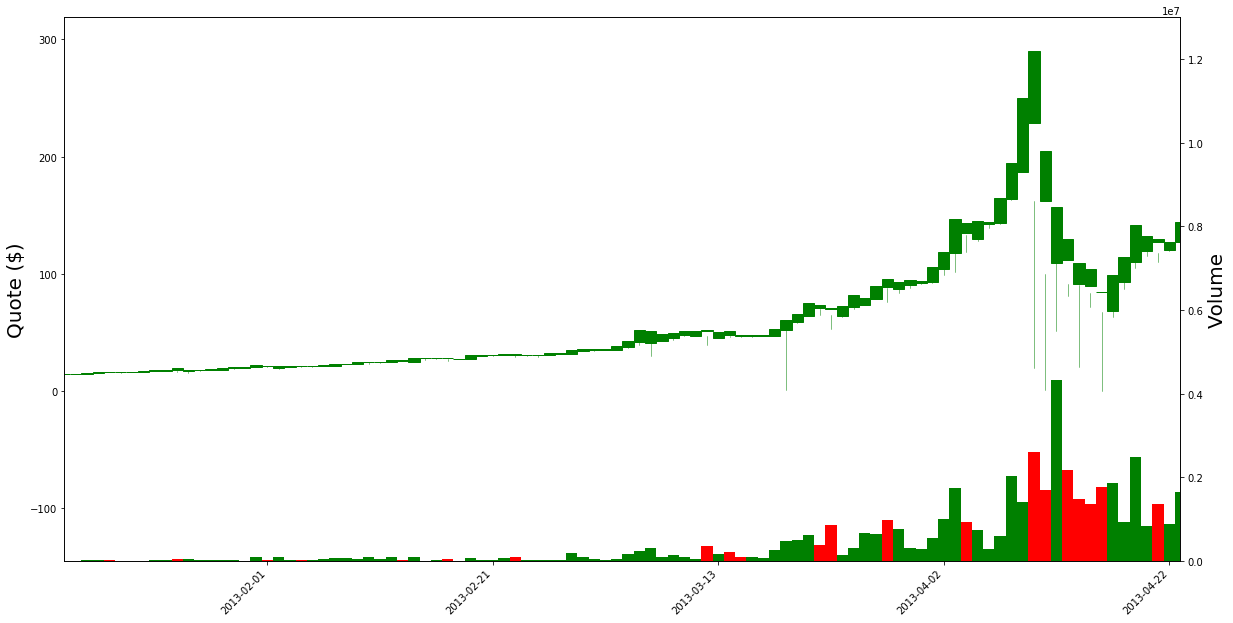

In [184]:
plotOHLC(df[:100])